## Lodaing The Required Libraries

In [1]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 11.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=2811598 sha256=9fee1c4ee1be922ad7fad4c742d0a51494c32aa5e007b330959daeb45d4156be
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [110]:
import numpy as np
from scipy.sparse import coo_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import SVD
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from surprise import accuracy
from sklearn.metrics.pairwise import cosine_similarity
import random

## Loading The Dataset

In [3]:
filename = 'overall_df.csv'
overall_df = pd.read_csv(filename)
overall_df = overall_df.drop(columns=['Population', 'Post_Title', 'Upvotes'])
overall_df.rename(columns={'PageRank_Within_Community': 'PR_Community'}, inplace=True)
overall_df.head()

,Subreddit,Date,User_ID,Community_Label,PageRank,PR_Community,Category
0,AdviceAnimals,8/31/2022,Lost-My-Mind-,0,0.000407,0.001599,Humor
1,AdviceAnimals,8/31/2022,SgtDoughnut,0,0.000137,0.000528,Humor
2,AdviceAnimals,8/31/2022,JasonDJ,0,0.000082,0.000312,Humor
3,AdviceAnimals,8/31/2022,tacknosaddle,0,0.000199,0.000771,Humor
4,AdviceAnimals,8/31/2022,jezra,0,0.000081,0.000309,Humor


## Creating List Of Community Dataframes

- The aim of this section is to create a list of dataframes, where each dataframe represent a specific community. The reason behind doing this is: The collaborative filtering process will be focused on each community seperately.

In [4]:
def create_community_dataframes(df):
  community_dataframes = []
  grouped = df.groupby('Community_Label')
  for community_id, community_nodes_df in grouped:
      # Removing the 'Community_Library' column from the DataFrame, as it's no longer needed
      community_nodes_df = community_nodes_df.drop(columns=['Community_Label'])
      community_dataframes.append(community_nodes_df)

  return community_dataframes

In [5]:
community_dfs = create_community_dataframes(overall_df)
for df in community_dfs:
    df['Date'] = pd.to_datetime(df['Date'])
print("\nCommunity X DataFrame:")
community_dfs[9].head(5)


Community X DataFrame:


,Subreddit,Date,User_ID,PageRank,PR_Community,Category
25616,AnimalsBeingDerps,2022-09-02,Sniflix,0.00018,0.002661,Animals and Pets
25618,AnimalsBeingDerps,2022-07-09,Sniflix,0.00018,0.002661,Animals and Pets
25634,AnimalsBeingDerps,2023-03-26,Sniflix,0.00018,0.002661,Animals and Pets
25700,AnimalsBeingDerps,2023-03-20,Sniflix,0.00018,0.002661,Animals and Pets
25941,AnimalsBeingDerps,2022-08-08,Sniflix,0.00018,0.002661,Animals and Pets


In [6]:
record_counts = [(i, len(df)) for i, df in enumerate(community_dfs)]
# Sorting the list of tuples in descending order based on record counts
sorted_record_counts = sorted(record_counts, key=lambda x: x[1], reverse=True)
# Extracting the top 3 DataFrames
top_3_dataframes = [community_dfs[i] for i, _ in sorted_record_counts[:3]]
for i, count in sorted_record_counts[:3]:
    print(f"DataFrame {i}: {count} records")

DataFrame 0: 194345 records
DataFrame 4: 69365 records
DataFrame 15: 48567 records


In [7]:
communities_to_keep = [0, 4, 15]
community_dfs = [community_dfs[i] for i in communities_to_keep]
community_dfs[1].head(5)

,Subreddit,Date,User_ID,PageRank,PR_Community,Category
38,AdviceAnimals,2022-08-25,Technologhee,0.000191,0.001274,Humor
98,AdviceAnimals,2023-02-19,Technologhee,0.000191,0.001274,Humor
127,AdviceAnimals,2022-09-05,Technologhee,0.000191,0.001274,Humor
136,AdviceAnimals,2022-11-02,Technologhee,0.000191,0.001274,Humor
140,AdviceAnimals,2023-06-06,Technologhee,0.000191,0.001274,Humor


## Data Preprocessing

- The aim of this section I start figuring out how can I create a score/rate that best describes the user preference regarding a given subreddit.
- I first compute the weights of the following subreddit and category. Each one describes the following: On average how many categories/subreddits does a user view.
- I then compute the partial scores, which are engagement score for subreddit and for category. These partial scores describe or give more importance to the subreddits/categories that have been interacted with more by the user. For example if the user have performed an interaction in a subreddit X four times and in subreddit Y 2 times, then I give more importance to subreddit X than subreddit Y.  
- Finally, I compute the decay factor, where I give more importance to a subreddit that has been interacted with several times in a day by a given user than a product that has been viewed several times but across several days that are far apart by the same user. The time decay factor was calculated by followaing the log approach, in order to give importance to reecency of the view date. For instance if user x has viewed product y today and yesterday the value of the decay factor won't be the same as when user x viewed product y today and 3 months ago.

In [8]:
def calculate_subreddit_weight(df):
    # Grouping by 'User_ID' and count distinct 'Subreddit'
    grouped = df.groupby('User_ID')['Subreddit'].nunique()
    average_count = grouped.mean()
    return average_count

def calculate_category_weight(df):
    # Grouping by 'User_ID' and count distinct 'Category'
    grouped = df.groupby('User_ID')['Category'].nunique()
    average_count = grouped.mean()
    return average_count

In [9]:
def calculate_interaction_ratio_subreddit(df):
    subreddit_interactions = df.groupby(['User_ID', 'Subreddit']).size().reset_index(name='interactions')
    total_interactions = df.groupby('User_ID').size().reset_index(name='total_interactions')

    df = df.merge(subreddit_interactions, on=['User_ID', 'Subreddit'], how='left')
    df = df.merge(total_interactions, on='User_ID', how='left')

    df['Engagement_Score_Subreddit'] = df['interactions'] / df['total_interactions']
    df = df.drop(['interactions', 'total_interactions'], axis=1)
    return df

def calculate_interaction_ratio_category(df):
    category_interactions = df.groupby(['User_ID', 'Category']).size().reset_index(name='interactions')
    total_interactions = df.groupby('User_ID').size().reset_index(name='total_interactions')

    df = df.merge(category_interactions, on=['User_ID', 'Category'], how='left')
    df = df.merge(total_interactions, on='User_ID', how='left')

    df['Engagement_Score_Category'] = df['interactions'] / df['total_interactions']
    df = df.drop(['interactions', 'total_interactions'], axis=1)
    return df

In [10]:
def max_date(df):
    # Calculating the maximum date for each user-product combination
    max_date_df = df.groupby(['User_ID', 'Subreddit'])['Date'].max().reset_index()
    max_date_df.rename(columns={'Date': 'Last_Interaction_Date'}, inplace=True)

    # Joining the max_date_df with the original df
    df_with_max_date = df.merge(max_date_df, on=['User_ID', 'Subreddit'])
    return df_with_max_date

def calculate_decay_factor(row):
    half_life_days = 7
    days_diff = abs((pd.to_datetime(row['Date']) - pd.to_datetime(row['Last_Interaction_Date'])).days)
    if days_diff == 0:
        return 1
    return 1 / np.log1p(1 + (days_diff / half_life_days))

In [11]:
subreddit_weight = []
for df in community_dfs:
    subreddit_weight.append(calculate_subreddit_weight(df))

category_weight = []
for df in community_dfs:
    category_weight.append(calculate_category_weight(df))

In [12]:
temp_dfs_1 = []
for df in community_dfs:
    temp_dfs_1.append(calculate_interaction_ratio_subreddit(df))

temp_dfs_2 = []
for df in temp_dfs_1:
    temp_dfs_2.append(calculate_interaction_ratio_category(df))

In [13]:
max_date_dfs = []
for df in temp_dfs_2:
    max_date_dfs.append(max_date(df))
for df in max_date_dfs:
    df['Decay_Factor'] = df.apply(calculate_decay_factor, axis=1)
overall_dfs = max_date_dfs.copy()
overall_dfs[1].head()

,Subreddit,Date,User_ID,PageRank,PR_Community,Category,Engagement_Score_Subreddit,Engagement_Score_Category,Last_Interaction_Date,Decay_Factor
0,AdviceAnimals,2022-08-25,Technologhee,0.000191,0.001274,Humor,0.5625,0.5625,2023-07-01,0.260768
1,AdviceAnimals,2023-02-19,Technologhee,0.000191,0.001274,Humor,0.5625,0.5625,2023-07-01,0.329197
2,AdviceAnimals,2022-09-05,Technologhee,0.000191,0.001274,Humor,0.5625,0.5625,2023-07-01,0.263138
3,AdviceAnimals,2022-11-02,Technologhee,0.000191,0.001274,Humor,0.5625,0.5625,2023-07-01,0.278137
4,AdviceAnimals,2023-06-06,Technologhee,0.000191,0.001274,Humor,0.5625,0.5625,2023-07-01,0.582190


## Score Calculation

- In this section I compute the implicit score by firstly computing the following equation: (subreddit weight * engagement score subreddit + category weight * engagement score category)*decay factor.

- The result of this equation is then used to compute the actual implicit score by integrating the pagerank score.

- Alpha is a parameter that controls the balance between the Total_Score and the PageRank scores. Higher alpha gives more weight to pagerank scores, making the recommendations more influenced by user importance in the community.

- I then compute the lower and upper bounds based on the interquartile range (IQR) and capping the Implicit_Score values that fall outside these bounds. This helps in mitigating the impact of outliers on your recommendations.

In [184]:
def calculate_implicit_score(df, subreddit_weight, category_weight, alpha):
    df['Total_Score'] = (subreddit_weight * df['Engagement_Score_Subreddit'] + category_weight * df['Engagement_Score_Category'])* df['Decay_Factor']
    df['Implicit_Score'] = (1 - alpha) * df['Total_Score'] + alpha * df['PR_Community']
    lower_quartile = df['Implicit_Score'].quantile(0.25)
    upper_quartile = df['Implicit_Score'].quantile(0.75)
    iqr = upper_quartile - lower_quartile

    # Calculating lower and upper bounds
    lower_bound = lower_quartile - 1.5 * iqr
    upper_bound = upper_quartile + 1.5 * iqr

    # Setting scores below lower bound to lower bound, and scores above upper bound to upper bound
    df['Implicit_Score'] = df['Implicit_Score'].apply(lambda x: lower_bound if x < lower_bound else x)
    df['Implicit_Score'] = df['Implicit_Score'].apply(lambda x: upper_bound if x > upper_bound else x)
    final_df = df.copy()
    return final_df

In [185]:
alpha = 0.7
main_dfs = []
for community_idx in range(len(overall_dfs)):
    community_df = overall_dfs[community_idx]
    community_subreddit_weight = subreddit_weight[community_idx]
    community_category_weight = category_weight[community_idx]
    implicit_score_df = calculate_implicit_score(community_df, community_subreddit_weight, community_category_weight, alpha)
    avg_implicit_score_df = implicit_score_df.groupby(['User_ID', 'Subreddit'])['Implicit_Score'].mean().reset_index()
    main_dfs.append(avg_implicit_score_df)
main_dfs[1].head()

,User_ID,Subreddit,Implicit_Score
0,--leockl--,CryptoCurrency,0.200646
1,-5m,CryptoCurrency,0.295662
2,-xstatic-,CryptoCurrency,0.231629
3,002_timmy,CryptoCurrency,0.289477
4,002timmy,CryptoCurrency,0.242601


## Normalizing The Scores

In [186]:
def normalize_score(dfs):
    score_normalized_dfs = []
    for df in dfs:
        min_score = df["Implicit_Score"].min()
        max_score = df["Implicit_Score"].max()

        def normalize(x):
            return (x - min_score) / (max_score - min_score)

        # Apply normalization to the DataFrame
        df["Score_Normalized"] = df["Implicit_Score"].apply(normalize)
        score_normalized_dfs.append(df)

    print("normalize_score completed")
    return score_normalized_dfs

In [187]:
norm_dfs = normalize_score(main_dfs)
for i in range(len(norm_dfs)):
    norm_dfs[i]["Score_Normalized"] = norm_dfs[i]["Score_Normalized"].astype(float)
norm_dfs[0].head()

normalize_score completed


,User_ID,Subreddit,Implicit_Score,Score_Normalized
0,-FeistyRabbitSauce-,television,0.279829,0.571891
1,-SneakySnake-,movies,0.276939,0.565661
2,-The_Blazer-,Futurology,0.278530,0.569091
3,-doitforjohnny-,photoshopbattles,0.297810,0.610641
4,0002millertime,politics,0.246815,0.500741


# Collaborating Filtering Recommendation System

The aim of this section is performing matrix factorization using the Singular Value Decomposition (SVD) technique with the Surprise library, making recommendations based on user-item interactions and item-item similarities.

In order to do so I decided to implement collaborative filtering approach. I divided this process into 4 sections:
- Implement Matrix factorization using SVD
- Identifying the optimal number of latent factors for each community
- fitting model on training set and testing its accuracy on a test set for each community
- Generating recommendations, 2 types of recommendations
    - recommending subreddits for a given user
    - recommending similar subreddits to a subreddit that has been 'viewed' or 'interacted' with

## Filtering Dataframes Based On User Interactions

In [189]:
users_with_multiple_interactions_dfs = []
for idx, norm_df in enumerate(norm_dfs):
    user_subreddit_counts = norm_df.groupby('User_ID')['Subreddit'].nunique()
    users_with_multiple_subreddits = user_subreddit_counts[user_subreddit_counts >= 1]
    num_users_with_multiple_subreddits = len(users_with_multiple_subreddits)
    print(f'Number of users in community {idx} who interacted with more than one subreddit: {num_users_with_multiple_subreddits}')

    users_with_multiple_interactions_df = norm_df[norm_df['User_ID'].isin(users_with_multiple_subreddits.index)]
    num_records = len(users_with_multiple_interactions_df)
    print(f'Number of records in the DataFrame with users who interacted more than once: {num_records}')

    users_with_multiple_interactions_dfs.append(users_with_multiple_interactions_df)

Number of users in community 0 who interacted with more than one subreddit: 2369
Number of records in the DataFrame with users who interacted more than once: 3172
Number of users in community 1 who interacted with more than one subreddit: 793
Number of records in the DataFrame with users who interacted more than once: 845
Number of users in community 2 who interacted with more than one subreddit: 728
Number of records in the DataFrame with users who interacted more than once: 789


## Finding Best Number of Latent Factors & Best Model

In [190]:
def find_best_num_factors(df):
      reader = Reader(rating_scale=(0, 1))

      # Loading the dataset into the Surprise format
      data = Dataset.load_from_df(df[['User_ID', 'Subreddit', 'Score_Normalized']], reader)

      latent_factors = [3, 5, 10, 15, 20]

      results = []
      for num_factors in latent_factors:
          model = SVD(n_factors=num_factors, random_state=42)

          cv_results = cross_validate(model, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)

          results.append({
              'Latent Factors': num_factors,
              'RMSE Mean': cv_results['test_rmse'].mean(),
              'MAE Mean': cv_results['test_mae'].mean()
          })

      # Converting the results to a DataFrame for easy analysis
      results_df = pd.DataFrame(results)
      plt.figure(figsize=(10, 6))
      plt.plot(results_df['Latent Factors'], results_df['RMSE Mean'], marker='o', linestyle='-')
      plt.title('RMSE vs. Number of Latent Factors')
      plt.xlabel('Number of Latent Factors')
      plt.ylabel('RMSE Mean')
      plt.grid(True)
      plt.show()

      best_num_factors = results_df.loc[results_df['RMSE Mean'].idxmin()]['Latent Factors']
      print(f'Best Number of Latent Factors: {best_num_factors}')
      return best_num_factors

In [191]:
def svd_matrix_factorization(df, num_factors):

  model = SVD(n_factors=num_factors, random_state=42)

  train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

  # Loading the training data back into a Surprise dataset
  train_data = Dataset.load_from_df(train_df[['User_ID', 'Subreddit', 'Score_Normalized']], reader)
  trainset = train_data.build_full_trainset()

  model.fit(trainset)
  return train_df, test_df, model

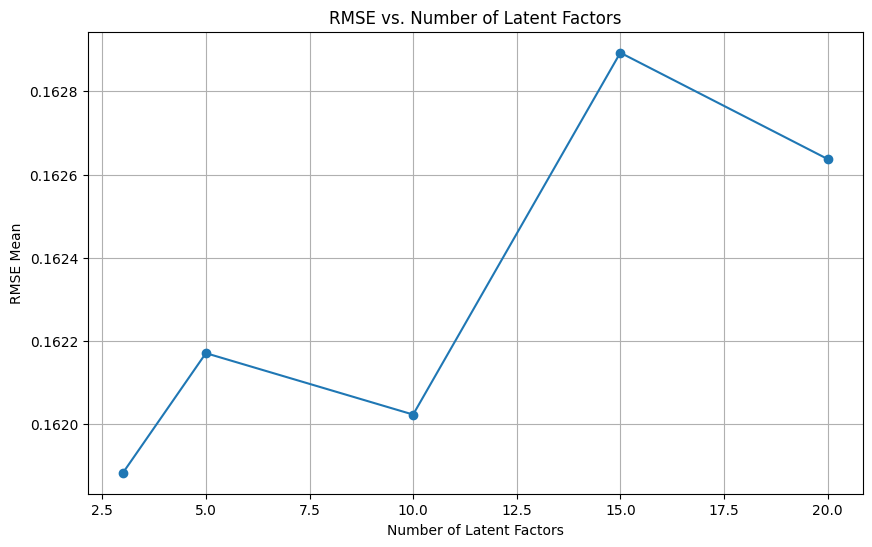

Best Number of Latent Factors: 3.0
RMSE: 0.1578
MAE:  0.1350
RMSE on Test Set: 0.15775716192748182
MAE on Test Set: 0.1349502465047595


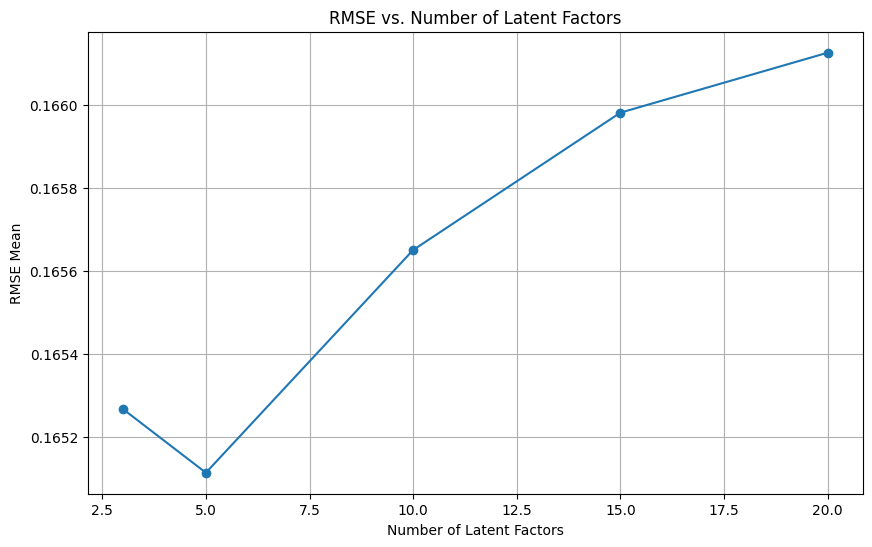

Best Number of Latent Factors: 5.0
RMSE: 0.1700
MAE:  0.1215
RMSE on Test Set: 0.17003108824887153
MAE on Test Set: 0.12153126490368875


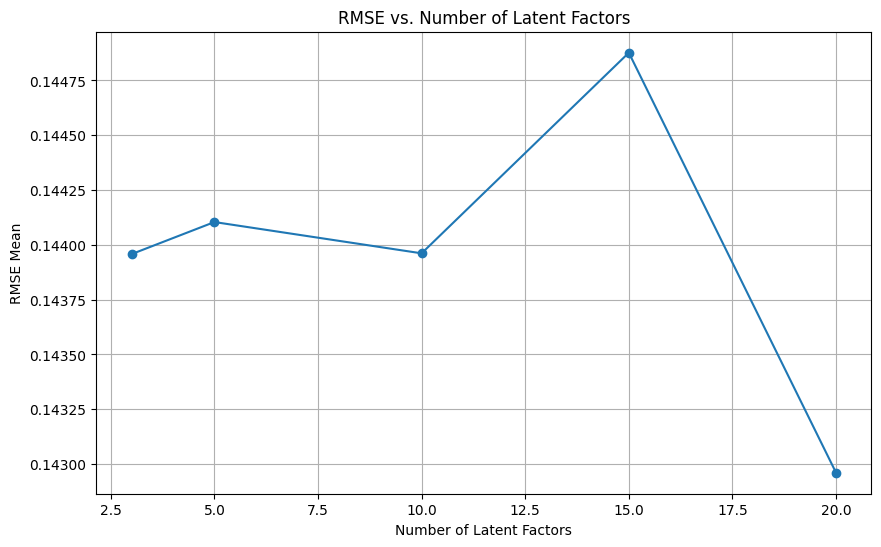

Best Number of Latent Factors: 20.0
RMSE: 0.1630
MAE:  0.1103
RMSE on Test Set: 0.16302367805814347
MAE on Test Set: 0.11028946109264706


In [192]:
final_model_list = []
for users_with_multiple_interactions_df in users_with_multiple_interactions_dfs:

  best_num_factors = int(find_best_num_factors(users_with_multiple_interactions_df))
  reader = Reader(rating_scale=(0, 1))

  # Loading the dataset into the Surprise format
  data = Dataset.load_from_df(users_with_multiple_interactions_df[['User_ID', 'Subreddit', 'Score_Normalized']], reader)
  df_surprise = pd.DataFrame(data.raw_ratings, columns=['User_ID', 'Subreddit', 'Score_Normalized', 'Extra_Column'])

  # Removing the 'Extra_Column' that contains None values
  df_surprise = df_surprise[['User_ID', 'Subreddit', 'Score_Normalized']]

  train, test, final_model = svd_matrix_factorization(df_surprise, best_num_factors)
  testset = [(row['User_ID'], row['Subreddit'], row['Score_Normalized']) for _, row in test.iterrows()]

  # Making predictions on the test set
  test_predictions = final_model.test(testset)

  rmse = accuracy.rmse(test_predictions)
  mae = accuracy.mae(test_predictions)

  print(f'RMSE on Test Set: {rmse}')
  print(f'MAE on Test Set: {mae}')

  final_model_list.append(final_model)

## Generating Recommendations (User-Item-based Approach | Item-based Approach)

In [193]:
def generate_top_N_recommendations_user_item_based(df, model, user_id, N):
  all_subreddits = df['Subreddit'].unique()

  # Creating a list of items the user has already interacted with
  user_interactions = df[df['User_ID'] == user_id]['Subreddit'].unique()

  # Filtering out the items the user has already interacted with
  items_to_recommend = np.setdiff1d(all_subreddits, user_interactions)

  # Generating predicted scores for the user for all items to recommend
  predicted_scores_dict = {}
  for item_id in items_to_recommend:
      predicted_score = model.predict(user_id, item_id).est
      predicted_scores_dict[item_id] = predicted_score

  # Sorting the items by predicted rating in descending order to get top recommendations
  top_N_recommendations = sorted(predicted_scores_dict.keys(), key=lambda item: predicted_scores_dict[item], reverse=True)[:N]

  print(f'Top {N} Recommendations for User {user_id}:')
  for rank, item_id in enumerate(top_N_recommendations, start=1):
      predicted_score = predicted_scores_dict[item_id]
      print(f'{rank}. Subreddit: {item_id}, Predicted Score: {predicted_score:.2f}')

In [194]:
def generate_top_N_recommendations_item_based(df, model, user_id, N):
  # Calculating cosine similarities between items (subreddits) to find similar items
  item_factors = model.qi
  cosine_similarities = cosine_similarity(item_factors)

  subreddit_name = random.choice(df['Subreddit'])
  all_subreddits = df['Subreddit'].unique()

  # Get the index of the given subreddit in the list of all subreddits
  subreddit_index = np.where(all_subreddits == subreddit_name)[0][0]

  # Calculating cosine similarities between the given subreddit and all other subreddits
  similarities = cosine_similarities[subreddit_index]

  # Sorting subreddits by similarity in descending order to get top similar subreddits
  top_similar_subreddits_indices = similarities.argsort()[::-1]

  top_N_similar_subreddits = [subreddit for subreddit in all_subreddits[top_similar_subreddits_indices] if subreddit not in subreddit_name][:N]
  print(f'Top {N} Similar Subreddits to {subreddit_name}:')
  for rank, similar_subreddit in enumerate(top_N_similar_subreddits, start=1):
      print(f'{rank}. Subreddit: {similar_subreddit}, Similarity: {similarities[top_similar_subreddits_indices[rank - 1]]:.2f}')

In [195]:
for users_with_multiple_interactions_df, final_model in zip(users_with_multiple_interactions_dfs, final_model_list):
  random_user = random.choice(users_with_multiple_interactions_df['User_ID'])
  generate_top_N_recommendations_user_item_based(users_with_multiple_interactions_df, final_model, random_user, 10)
  print('------------------------------------------------------------------------------')
  generate_top_N_recommendations_item_based(users_with_multiple_interactions_df, final_model, random_user, 10)
  print('------------------------------------------------------------------------------')
  print('------------------------------------------------------------------------------')

Top 10 Recommendations for User marriedacarrot:
1. Subreddit: philosophy, Predicted Rating: 0.55
2. Subreddit: Whatcouldgowrong, Predicted Rating: 0.52
3. Subreddit: photoshopbattles, Predicted Rating: 0.52
4. Subreddit: tattoos, Predicted Rating: 0.52
5. Subreddit: history, Predicted Rating: 0.51
6. Subreddit: sports, Predicted Rating: 0.51
7. Subreddit: GetMotivated, Predicted Rating: 0.51
8. Subreddit: explainlikeimfive, Predicted Rating: 0.51
9. Subreddit: Awwducational, Predicted Rating: 0.51
10. Subreddit: books, Predicted Rating: 0.51
------------------------------------------------------------------------------
Top 10 Similar Subreddits to books:
1. Subreddit: Showerthoughts, Similarity: 1.00
2. Subreddit: gardening, Similarity: 0.98
3. Subreddit: FoodPorn, Similarity: 0.95
4. Subreddit: GetMotivated, Similarity: 0.93
5. Subreddit: tifu, Similarity: 0.93
6. Subreddit: Documentaries, Similarity: 0.87
7. Subreddit: HistoryMemes, Similarity: 0.85
8. Subreddit: news, Similarity: 0.